In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw
from keras.preprocessing.sequence import pad_sequences

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [6]:
df_cytokine = pd.read_csv("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/Cytokine_Data.csv")
df_cytokine["Date of Sample"] = pd.to_datetime(df_cytokine['Date of Sample'])
df_cytokine

,Date of Sample,Sample ID,PT_ID,Agent (JNJ/BMS/Caribou),Date of CAR-T infusion,Age,Days in relation to CAR-T infusion,Patient experienced CRS at any point (Yes/No),"CRS on date (0 No, 1 Yes)",CRS Grade,...,IL12RB1,IL13,CCL20,TNF,KLRD1,GZMB,CD83,IL12,CSF-1,Hours
0,2022-10-21 00:00:00,WEAR_7001_V1,WEAR_7001,BMS,10/21/22,83,0,1,1,1,...,2.960060,1.137010,8.961000,3.789520,4.535950,0.267810,2.691600,5.689550,9.600130,0
1,2022-10-21 01:00:00,WEAR_7001_V1,WEAR_7001,BMS,10/21/22,83,0,1,1,1,...,2.974149,1.142760,8.997290,3.849518,4.538004,0.383493,2.701781,5.704185,9.613018,1
2,2022-10-21 02:00:00,WEAR_7001_V1,WEAR_7001,BMS,10/21/22,83,0,1,1,1,...,2.988237,1.148510,9.033580,3.909515,4.540058,0.499176,2.711963,5.718820,9.625906,2
3,2022-10-21 03:00:00,WEAR_7001_V1,WEAR_7001,BMS,10/21/22,83,0,1,1,1,...,3.002326,1.154260,9.069870,3.969512,4.542112,0.614859,2.722144,5.733455,9.638794,3
4,2022-10-21 04:00:00,WEAR_7001_V1,WEAR_7001,BMS,10/21/22,83,0,1,1,1,...,3.016415,1.160010,9.106160,4.029510,4.544167,0.730542,2.732325,5.748090,9.651682,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,2023-10-23 20:00:00,WEAR_7029_V17,WEAR_7029,BMS,2023-10-11,58,13,1,0,0,...,2.159645,1.002972,8.171895,3.893580,4.340152,2.305510,2.591648,5.142338,9.303672,20
8829,2023-10-23 21:00:00,WEAR_7029_V17,WEAR_7029,BMS,2023-10-11,58,13,1,0,0,...,2.151169,0.983464,8.165616,3.884298,4.334866,2.342777,2.592066,5.145424,9.299034,21
8830,2023-10-23 22:00:00,WEAR_7029_V17,WEAR_7029,BMS,2023-10-11,58,13,1,0,0,...,2.142692,0.963956,8.159337,3.875015,4.329581,2.380045,2.592484,5.148509,9.294396,22
8831,2023-10-23 23:00:00,WEAR_7029_V17,WEAR_7029,BMS,2023-10-11,58,13,1,0,0,...,2.134216,0.944448,8.153059,3.865733,4.324295,2.417312,2.592902,5.151595,9.289758,23


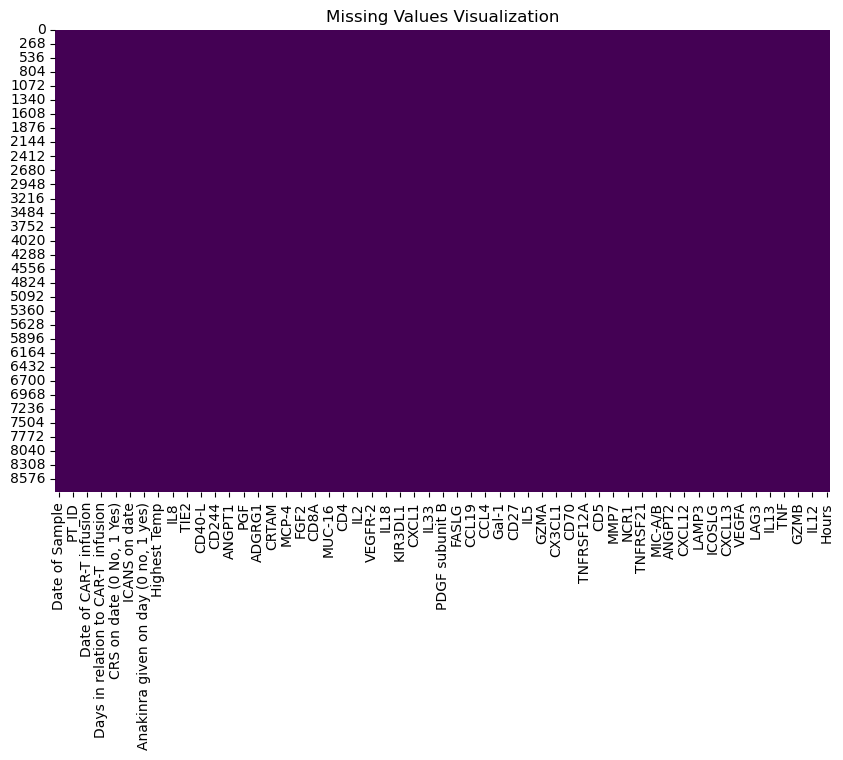

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cytokine.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Visualization")
plt.show()

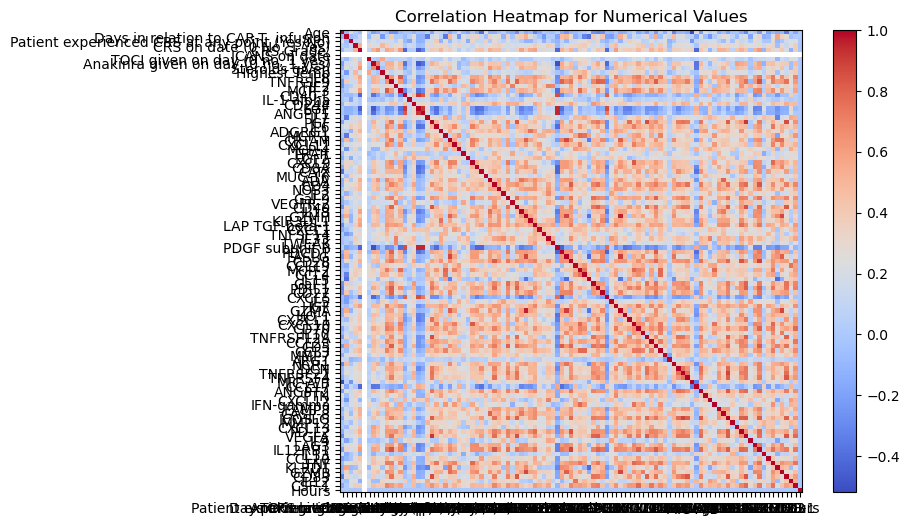

In [8]:
#draw a correlation heatmap
numerical_df = df_cytokine.select_dtypes(include=[np.number])
corr_matrix = numerical_df.corr()

plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(numerical_df.columns)),numerical_df.columns)
plt.yticks(range(len(numerical_df.columns)), numerical_df.columns)
plt.title("Correlation Heatmap for Numerical Values")
plt.show()

In [9]:
df_cytokine.columns

Index(['Date of Sample', 'Sample ID', 'PT_ID', 'Agent (JNJ/BMS/Caribou)',
       'Date of CAR-T infusion', 'Age', 'Days in relation to CAR-T  infusion',
       'Patient experienced CRS at any point (Yes/No)',
       'CRS on date (0 No, 1 Yes)', 'CRS Grade ',
       ...
       'IL12RB1', 'IL13', 'CCL20', 'TNF', 'KLRD1', 'GZMB', 'CD83', 'IL12',
       'CSF-1', 'Hours'],
      dtype='object', length=109)

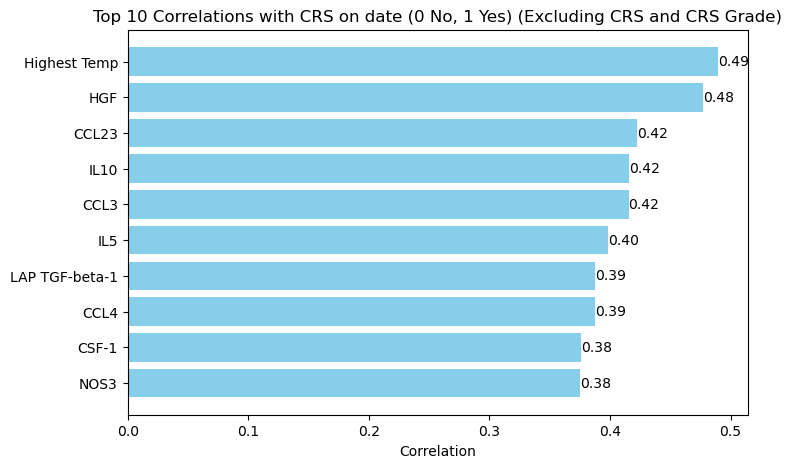

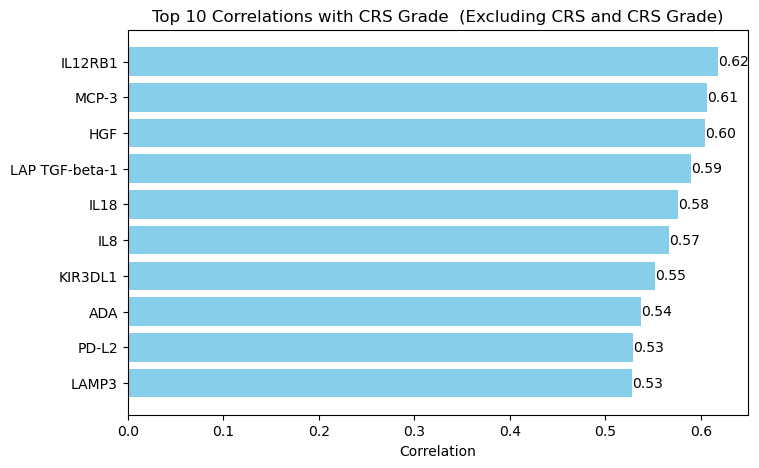

In [10]:
# Corrected code without syntax formatting errors
def plot_correlations(corr_matrix, target_column, top_n=10):
    # Extract the top correlations for the specified target column, excluding the first two ('self' and CRS grade)
    correlations = corr_matrix[target_column].sort_values(ascending=False).iloc[2:top_n + 2]
    
    # Create a bar plot
    plt.figure(figsize=(8, 5))
    bars = plt.barh(correlations.index, correlations.values, color='skyblue')
    plt.xlabel('Correlation')
    plt.title(f'Top {top_n} Correlations with {target_column} (Excluding CRS and CRS Grade)')
    plt.gca().invert_yaxis()  # To display the highest correlation on top

    # Annotate the bars with correlation values
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    plt.show()

    return correlations

# Assuming corr_matrix is your DataFrame containing the correlation values
CRS_correlations = plot_correlations(corr_matrix, 'CRS on date (0 No, 1 Yes)', top_n=10)
CRS_Grade_correlations = plot_correlations(corr_matrix, 'CRS Grade ', top_n=10)



In [11]:
CRS_correlations

Highest Temp      0.489735
HGF               0.476934
CCL23             0.422145
IL10              0.415791
CCL3              0.415430
IL5               0.398074
LAP TGF-beta-1    0.387855
CCL4              0.387494
CSF-1             0.375931
NOS3              0.375350
Name: CRS on date (0 No, 1 Yes), dtype: float64

In [12]:
def subtract_baseline(df, patient_col, biomarker_cols):
    """
    Subtracts the baseline values (first recorded value) for each biomarker for each patient.

    Parameters:
    df (pd.DataFrame): The input dataframe containing patient data.
    patient_col (str): The column representing patient IDs.
    biomarker_cols (list of str): The columns representing the biomarkers to adjust.

    Returns:
    pd.DataFrame: A dataframe with biomarker values adjusted by baseline.
    """
    # Sort the data by patient ID and time to ensure correct ordering
    df = df.sort_values([patient_col, 'Date of Sample'])

    # Function to subtract baseline for a single patient
    def subtract_patient_baseline(patient_df):
        # Get the first row (baseline values)
        baseline_values = patient_df.iloc[0][biomarker_cols]
        
        # Subtract baseline from each row for the relevant biomarkers
        patient_df[biomarker_cols] = patient_df[biomarker_cols] - baseline_values
        
        return patient_df
    
    # Apply the baseline subtraction for each patient
    df = df.groupby(patient_col, group_keys=False).apply(subtract_patient_baseline)
    
    return df

In [13]:
data = df_cytokine[[*CRS_correlations.index,'CRS on date (0 No, 1 Yes)','Date of Sample', 'PT_ID']]
data

,Highest Temp,HGF,CCL23,IL10,CCL3,IL5,LAP TGF-beta-1,CCL4,CSF-1,NOS3,"CRS on date (0 No, 1 Yes)",Date of Sample,PT_ID
0,101.800000,9.307330,10.893300,3.223290,6.498890,-0.426260,8.065760,7.245410,9.600130,1.521880,1,2022-10-21 00:00:00,WEAR_7001
1,101.795833,9.322132,10.910740,3.266901,6.531858,-0.366443,8.086281,7.311218,9.613018,1.526403,1,2022-10-21 01:00:00,WEAR_7001
2,101.791667,9.336933,10.928179,3.310512,6.564826,-0.306627,8.106802,7.377027,9.625906,1.530925,1,2022-10-21 02:00:00,WEAR_7001
3,101.787500,9.351735,10.945619,3.354122,6.597794,-0.246810,8.127324,7.442835,9.638794,1.535448,1,2022-10-21 03:00:00,WEAR_7001
4,101.783333,9.366537,10.963058,3.397733,6.630762,-0.186993,8.147845,7.508643,9.651682,1.539970,1,2022-10-21 04:00:00,WEAR_7001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,98.450000,8.041788,10.615655,5.106338,6.018253,-0.358282,8.245360,6.429510,9.303672,1.832047,0,2023-10-23 20:00:00,WEAR_7029
8829,98.487500,8.038116,10.593234,5.121226,6.018005,-0.383521,8.291430,6.438835,9.299034,1.849060,0,2023-10-23 21:00:00,WEAR_7029
8830,98.525000,8.034444,10.570813,5.136114,6.017757,-0.408761,8.337500,6.448160,9.294396,1.866073,0,2023-10-23 22:00:00,WEAR_7029
8831,98.562500,8.030772,10.548391,5.151002,6.017508,-0.434000,8.383570,6.457485,9.289758,1.883087,0,2023-10-23 23:00:00,WEAR_7029


In [14]:
# List all columns that are biomarkers
biomarker_cols = [col for col in data.columns if col not in ['PT_ID', 'Date of Sample', 'CRS on date (0 No, 1 Yes)']]

# Call the subtract_baseline function once, passing the list of biomarker columns
data = subtract_baseline(data, 'PT_ID', biomarker_cols)

# Show the resulting dataframe
data


,Highest Temp,HGF,CCL23,IL10,CCL3,IL5,LAP TGF-beta-1,CCL4,CSF-1,NOS3,"CRS on date (0 No, 1 Yes)",Date of Sample,PT_ID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2022-10-21 00:00:00,WEAR_7001
1,-0.004167,0.014802,0.01744,0.043611,0.032968,0.059817,0.020521,0.065808,0.012888,0.004523,1,2022-10-21 01:00:00,WEAR_7001
2,-0.008333,0.029603,0.034879,0.087222,0.065936,0.119633,0.041042,0.131617,0.025776,0.009045,1,2022-10-21 02:00:00,WEAR_7001
3,-0.0125,0.044405,0.052319,0.130832,0.098904,0.17945,0.061564,0.197425,0.038664,0.013568,1,2022-10-21 03:00:00,WEAR_7001
4,-0.016667,0.059207,0.069758,0.174443,0.131872,0.239267,0.082085,0.263233,0.051552,0.01809,1,2022-10-21 04:00:00,WEAR_7001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,-0.55,-0.611042,-0.677865,-0.190252,-1.095277,-1.049042,-0.07413,-1.09176,-0.800598,0.671337,0,2023-10-23 20:00:00,WEAR_7029
8829,-0.5125,-0.614714,-0.700286,-0.175364,-1.095525,-1.074281,-0.02806,-1.082435,-0.805236,0.68835,0,2023-10-23 21:00:00,WEAR_7029
8830,-0.475,-0.618386,-0.722707,-0.160476,-1.095773,-1.099521,0.01801,-1.07311,-0.809874,0.705363,0,2023-10-23 22:00:00,WEAR_7029
8831,-0.4375,-0.622058,-0.745129,-0.145588,-1.096022,-1.12476,0.06408,-1.063785,-0.814512,0.722377,0,2023-10-23 23:00:00,WEAR_7029


In [15]:
# Step 1: Create lagged features for biomarkers (e.g., look at the last 3 time steps)
# Only keep the columns with top 10 pearson correlations


lags = 3
for col in CRS_correlations.index:
    for lag in range(1, lags+1):
        data[f'{col}_lag_{lag}'] = data[col].shift(lag)

# Drop rows with NaN values after creating lagged features
data.dropna(inplace=True)
data = data.drop(columns=biomarker_cols, axis = 1)
data


,"CRS on date (0 No, 1 Yes)",Date of Sample,PT_ID,Highest Temp_lag_1,Highest Temp_lag_2,Highest Temp_lag_3,HGF_lag_1,HGF_lag_2,HGF_lag_3,CCL23_lag_1,...,LAP TGF-beta-1_lag_3,CCL4_lag_1,CCL4_lag_2,CCL4_lag_3,CSF-1_lag_1,CSF-1_lag_2,CSF-1_lag_3,NOS3_lag_1,NOS3_lag_2,NOS3_lag_3
3,1,2022-10-21 03:00:00,WEAR_7001,-0.008333,-0.004167,0.0,0.029603,0.014802,0.0,0.034879,...,0.0,0.131617,0.065808,0.0,0.025776,0.012888,0.0,0.009045,0.004523,0.0
4,1,2022-10-21 04:00:00,WEAR_7001,-0.0125,-0.008333,-0.004167,0.044405,0.029603,0.014802,0.052319,...,0.020521,0.197425,0.131617,0.065808,0.038664,0.025776,0.012888,0.013568,0.009045,0.004523
5,1,2022-10-21 05:00:00,WEAR_7001,-0.016667,-0.0125,-0.008333,0.059207,0.044405,0.029603,0.069758,...,0.041042,0.263233,0.197425,0.131617,0.051552,0.038664,0.025776,0.01809,0.013568,0.009045
6,1,2022-10-21 06:00:00,WEAR_7001,-0.020833,-0.016667,-0.0125,0.074008,0.059207,0.044405,0.087198,...,0.061564,0.329042,0.263233,0.197425,0.06444,0.051552,0.038664,0.022612,0.01809,0.013568
7,1,2022-10-21 07:00:00,WEAR_7001,-0.025,-0.020833,-0.016667,0.08881,0.074008,0.059207,0.104638,...,0.082085,0.39485,0.329042,0.263233,0.077327,0.06444,0.051552,0.027135,0.022612,0.01809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,0,2023-10-23 20:00:00,WEAR_7029,-0.5875,-0.625,-0.6625,-0.60737,-0.603697,-0.600025,-0.655444,...,-0.21234,-1.101085,-1.11041,-1.119735,-0.79596,-0.791322,-0.786685,0.654323,0.63731,0.620297
8829,0,2023-10-23 21:00:00,WEAR_7029,-0.55,-0.5875,-0.625,-0.611042,-0.60737,-0.603697,-0.677865,...,-0.16627,-1.09176,-1.101085,-1.11041,-0.800598,-0.79596,-0.791322,0.671337,0.654323,0.63731
8830,0,2023-10-23 22:00:00,WEAR_7029,-0.5125,-0.55,-0.5875,-0.614714,-0.611042,-0.60737,-0.700286,...,-0.1202,-1.082435,-1.09176,-1.101085,-0.805236,-0.800598,-0.79596,0.68835,0.671337,0.654323
8831,0,2023-10-23 23:00:00,WEAR_7029,-0.475,-0.5125,-0.55,-0.618386,-0.614714,-0.611042,-0.722707,...,-0.07413,-1.07311,-1.082435,-1.09176,-0.809874,-0.805236,-0.800598,0.705363,0.68835,0.671337


In [16]:
# Step 2: Define features (X) and target (y)
features = [col for col in data.columns if col not in ['PT_ID','Date of Sample', 'CRS on date (0 No, 1 Yes)']]
X = data[features]
y = data['CRS on date (0 No, 1 Yes)']

# Step 3: Split the data into train and test sets (use a time-based split to avoid data leakage)
train_size = int(0.8 * len(data))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Fit logistic regression model
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')
logistic_model.fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
y_pred = logistic_model.predict(X_test)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9139297848244621
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95      1740
           1       0.14      0.96      0.25        26

    accuracy                           0.91      1766
   macro avg       0.57      0.94      0.60      1766
weighted avg       0.99      0.91      0.94      1766



In [17]:
from sklearn.metrics import confusion_matrix


# Ensure the correct order: true labels first, then predictions
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[1589  151]
 [   1   25]]


In [18]:
true_positive = np.sum((y_test == 1) & (y_pred == 1))
true_negative = np.sum((y_test == 0) & (y_pred == 0))
false_positive = np.sum((y_test == 0) & (y_pred == 1))
false_negative = np.sum((y_test == 1) & (y_pred == 0))

print("True Positives (1,1):", true_positive)
print("True Negatives (0,0):", true_negative)
print("False Positives (0,1):", false_positive)
print("False Negatives (1,0):", false_negative)



True Positives (1,1): 25
True Negatives (0,0): 1589
False Positives (0,1): 151
False Negatives (1,0): 1


In [49]:
# Step 5: Make probability predictions
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Step 6: Find the best threshold for 100% recall for class 1 and maximum accuracy
best_threshold = 0.5
highest_accuracy = 0
best_y_pred = None

# Loop over thresholds from 0 to 1 with a step of 0.01
for threshold in [i * 0.01 for i in range(1, 100)]:
    # Apply the threshold to get predictions
    y_pred_thresholded = (y_pred_proba >= threshold).astype(int)
    
    # Calculate recall for class 1
    recall_class_1 = recall_score(y_test, y_pred_thresholded, pos_label=1)
    
    # If recall for class 1 is 100%, check the accuracy
    if recall_class_1 == 1.0:
        accuracy = accuracy_score(y_test, y_pred_thresholded)
        
        # Update the best threshold and highest accuracy if this is the best so far
        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_threshold = threshold
            best_y_pred = y_pred_thresholded

# Print the best threshold and corresponding performance metrics
print(f"Best Threshold: {best_threshold}")
print(f"Highest Accuracy with 100% Recall for Class 1: {highest_accuracy}")
print("Classification Report at Best Threshold:\n", classification_report(y_test, best_y_pred))

Best Threshold: 0.29
Highest Accuracy with 100% Recall for Class 1: 0.8397508493771234
Classification Report at Best Threshold:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91      1740
           1       0.08      1.00      0.16        26

    accuracy                           0.84      1766
   macro avg       0.54      0.92      0.53      1766
weighted avg       0.99      0.84      0.90      1766



In [20]:
import numpy as np

y_pred = np.array(y_pred)
y_test = np.array(y_test)

pred_test_dataset = pd.DataFrame()
pred_test_dataset["y_pred"] = y_pred
pred_test_dataset["y_test"] = y_test


In [21]:
import pandas as pd

# Set pandas option to display all rows
pd.set_option('display.max_rows', None)

# Now print the full CRS data (replace 'data' with your actual DataFrame or Series variable name)
print(pred_test_dataset)

# If you want to reset it back to the default after checking the data
pd.reset_option('display.max_rows')

      y_pred  y_test
0          0       0
1          0       0
2          0       0
3          0       0
4          0       0
5          0       0
6          0       0
7          0       0
8          0       0
9          0       0
10         0       0
11         0       0
12         0       0
13         0       0
14         0       0
15         0       0
16         0       0
17         0       0
18         0       0
19         0       0
20         0       0
21         0       0
22         0       0
23         0       0
24         0       0
25         0       0
26         0       0
27         0       0
28         0       0
29         0       0
30         0       0
31         0       0
32         0       0
33         0       0
34         0       0
35         0       0
36         0       0
37         0       0
38         0       0
39         0       0
40         0       0
41         0       0
42         0       0
43         0       0
44         0       0
45         0       0
46         0 

In [26]:
# Step 1: Identify columns with object dtype
object_columns = X_train.select_dtypes(include=['object']).columns
print("Columns with object data type:", object_columns)

# Step 2: Convert columns to numeric (if they contain numeric values as strings)
for col in object_columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Step 3: Check for any remaining NaN values that may have been introduced during conversion
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


Columns with object data type: Index(['Highest Temp_lag_1', 'Highest Temp_lag_2', 'Highest Temp_lag_3',
       'HGF_lag_1', 'HGF_lag_2', 'HGF_lag_3', 'CCL23_lag_1', 'CCL23_lag_2',
       'CCL23_lag_3', 'IL10_lag_1', 'IL10_lag_2', 'IL10_lag_3', 'CCL3_lag_1',
       'CCL3_lag_2', 'CCL3_lag_3', 'IL5_lag_1', 'IL5_lag_2', 'IL5_lag_3',
       'LAP TGF-beta-1_lag_1', 'LAP TGF-beta-1_lag_2', 'LAP TGF-beta-1_lag_3',
       'CCL4_lag_1', 'CCL4_lag_2', 'CCL4_lag_3', 'CSF-1_lag_1', 'CSF-1_lag_2',
       'CSF-1_lag_3', 'NOS3_lag_1', 'NOS3_lag_2', 'NOS3_lag_3'],
      dtype='object')


/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_81286/2873975307.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_81286/2873975307.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_81286/2873975307.py:11: SettingWithCopyWarning: 
A value is trying to be set on

In [32]:
class_counts

Counter({0: 6714, 1: 350})

In [33]:
len(y_train)

7064

[0.0001548  0.00014399 0.00014399 ... 0.00023622 0.00045425 0.00132202]
Accuracy: 0.8986409966024915
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95      1740
           1       0.12      0.96      0.22        26

    accuracy                           0.90      1766
   macro avg       0.56      0.93      0.58      1766
weighted avg       0.99      0.90      0.94      1766



/Users/a123/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:13:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


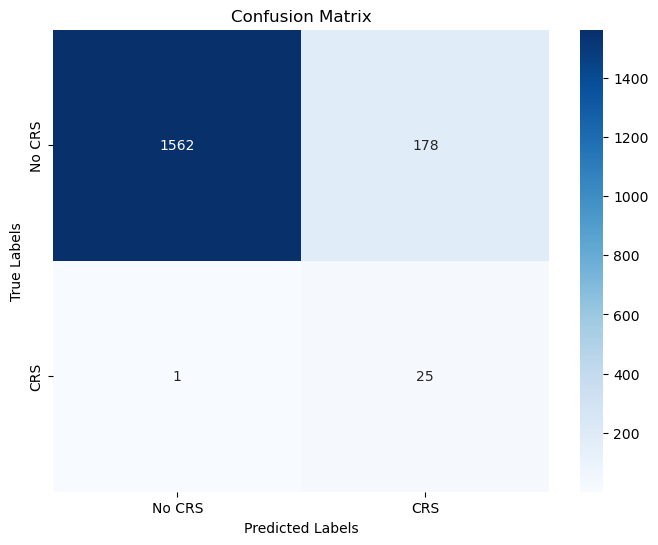

In [38]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]

# Step 1: Define the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, scale_pos_weight=scale_pos_weight)

# Step 2: Train the model
xgb_model.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = xgb_model.predict(X_test)

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
print(y_pred_proba)
custom_threshold = 0.001  # Experiment with values lower than 0.5
y_pred_custom = (y_pred_proba >= custom_threshold).astype(int)

y_pred = y_pred_custom

# Step 4: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 5: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CRS', 'CRS'], yticklabels=['No CRS', 'CRS'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [48]:
from sklearn.metrics import accuracy_score, recall_score, classification_report

# Get probabilities for the positive class (class 1)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Initialize variables to track the best threshold and highest accuracy with 100% recall for class 1
best_threshold = 1
highest_recall = 0
highest_accuracy = 0
best_y_pred = None

# Loop over thresholds from 0 to 1 with a step of 0.01
for threshold in [i * 0.0001 for i in range(1, 10000)]:
    # Apply the threshold to get predictions
    y_pred_thresholded = (y_pred_proba >= threshold).astype(int)
    
    # Calculate recall for class 1
    recall_class_1 = recall_score(y_test, y_pred_thresholded, pos_label=1)
    
    # If recall for class 1 is 100%, check the accuracy
    if recall_class_1 >= highest_recall:
        highest_recall = recall_class_1
        accuracy = accuracy_score(y_test, y_pred_thresholded)
        
        # Update the best threshold and highest accuracy if this is the best so far
        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_threshold = threshold
            best_y_pred = y_pred_thresholded

# Print the best threshold and corresponding performance metrics
print(f"Best Threshold: {best_threshold}")
print(f"Best Recall: {highest_recall}")
print(f"Highest Accuracy with 100% Recall for Class 1: {highest_accuracy}")
print("Classification Report at Best Threshold:\n", classification_report(y_test, best_y_pred))


Best Threshold: 0.0009000000000000001
Best Recall: 1.0
Highest Accuracy with 100% Recall for Class 1: 0.8958097395243488
Classification Report at Best Threshold:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94      1740
           1       0.12      1.00      0.22        26

    accuracy                           0.90      1766
   macro avg       0.56      0.95      0.58      1766
weighted avg       0.99      0.90      0.93      1766

